# Wavepacket in a Potential Box



Lets have a look at a wavepacket in a potential box first. In this first part, we will solve the problem with with a set of eigenfunctions of the stationary solution.

In [2]:
try:
  import google.colab
  !pip install ipycanvas==0.11
  from google.colab import output
  output.enable_custom_widget_manager()
  IN_COLAB=True
except:
  IN_COLAB = False

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from scipy.fftpack import fft,ifft
from time import sleep,time

from ipycanvas import MultiCanvas, hold_canvas,Canvas


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# default values for plotting
plt.rcParams.update({'font.size': 16,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

## Problem Setup

The problem we want to tackle is no similar to the last lecture only that we are interested in the dynamics. 

![Particle_In_Box.png](Particle_In_Box.png)


For a potential box with infinite walls and width $d$, the potential energy in the box can be set to zero. 

The Schrödinger equation within the box therefore reduces to

\begin{equation}\label{eq:se}
-i\hbar\frac{\partial \Psi}{\partial t}=-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} \Psi 
\end{equation}

The stationary solution of this problem with infinite walls are just standing waves with an appropriate wavevector such that the wavefunction at the boundaries $x=0$ and $x=d$ are just zero.

\begin{equation}
\Psi_{n}(x,t)= \sqrt{\frac{2}{d}} \sin \left(\frac{n\pi}{d}x\right)
\end{equation}




It turns out, that we can use these steady state solutions to construct any time dependent solution. We just have to sum many (to be exact infite) steady state solutions with specific amplitudes. 

\begin{equation}\label{eq:psi}
\Psi(x,t)=\sum_{n=1}^\infty C_n(t) \sqrt{\frac{2}{d}}\sin\left(\frac{n\pi}{d}x\right)
\end{equation}

The $sine$ function represents the corresponding boundary conditions, i.e. that $\Psi(x=0)=0$ and $\Psi(x=d)=0$. The time dependence of the wave function is encoded in the prefactors $C_n(t)$. Inserting  this solution into the Schrödinger equation  yields

\begin{equation}
i\sum_{n=1}^\infty \dot{C}_n(t) \sqrt{\frac{2}{d}}\sin\left(\frac{n\pi}{d}x\right)=\frac{\hbar^2}{2m}\sum_{n=1}^\infty C_n(t) \sqrt{\frac{2}{d}}\frac{n^2\pi^2}{d^2}\sin\left(\frac{n\pi}{d}x\right)
\end{equation}




To obtain a differential equation for the coefficient $C_n(t)$ we multiply both sides of the latter equation with $\sin\left(\frac{l\pi}{d}x\right)$ and integrate from $0$ to $d$. Doing this on the left side yields

\begin{equation}
i\int_{0}^{d} \sum_{n=1}^\infty \dot{C}_n(t) \frac{2}{d}\sin\left(\frac{n\pi}{d}x\right)\sin\left(\frac{l\pi}{d}x\right)dx
\end{equation}

An equivalent operation can be carried out on the right side. The orthogonality of the $sine$-function basis yields only terms of the sum for $n=l$ and thus

\begin{equation}\label{eq:deq}
\dot{C}_n(t)=-i\frac{\hbar k^2}{2m}C_n(t)
\end{equation}


This differential equation can be solved by

\begin{equation}
C_n(t)=C_{0n} e^{\lambda t}
\end{equation}

which finally yields 

\begin{equation}
\lambda=-i\frac{\hbar k^2}{2m}=-i\omega
\end{equation}

with $k^2=\frac{n^2\pi^2}{d^2}$. 

Thus the final solution of the time dependent Schrödinger equation for a wave paket in a box potential reads

\begin{equation}
\Psi(x,t)=\sum_{n=1}^\infty C_{0n}\sqrt{\frac{2}{d}}  e^{-i\frac{\hbar n^2\pi^2}{2m d^2}t} \sin\left(\frac{n\pi}{d}x\right)
\end{equation}

The only thing we have to determine then are the coefficients $C_{0n}$, which follow from the initial conditions $\Psi(x,t=0)=\Psi(x)$. 

## Initial conditions



For this project $\Psi(x,t=0)$ shall be assumed to be a Gaussian wave packet centered at a specific position in the box. Also other initial conditions such as triangular shaped wavepackets may be considered. For the Gaussian wavepacket, we will use a simpler way, then the superposition. We will just assume a Gaussian envelope of our plane wave, which is actually totally equivalent to our previous superposition. For simplicity assume that the mass of the particle is just 1 as well as $\hbar=1$. Our Gaussian wavepacket will be centered in the box and we will not supply any momentum in any direction. 

In [4]:
def gauss_x(x, sigma, x0, k0):
    tmp=np.exp(-0.5 * ((x - x0)/ sigma) ** 2 + 1j * x * k0)/(sigma * np.sqrt(np.pi))
    norm=np.sum(np.abs(tmp)**2)
    return (tmp/np.sqrt(norm))

Let's plot this wavefunction.

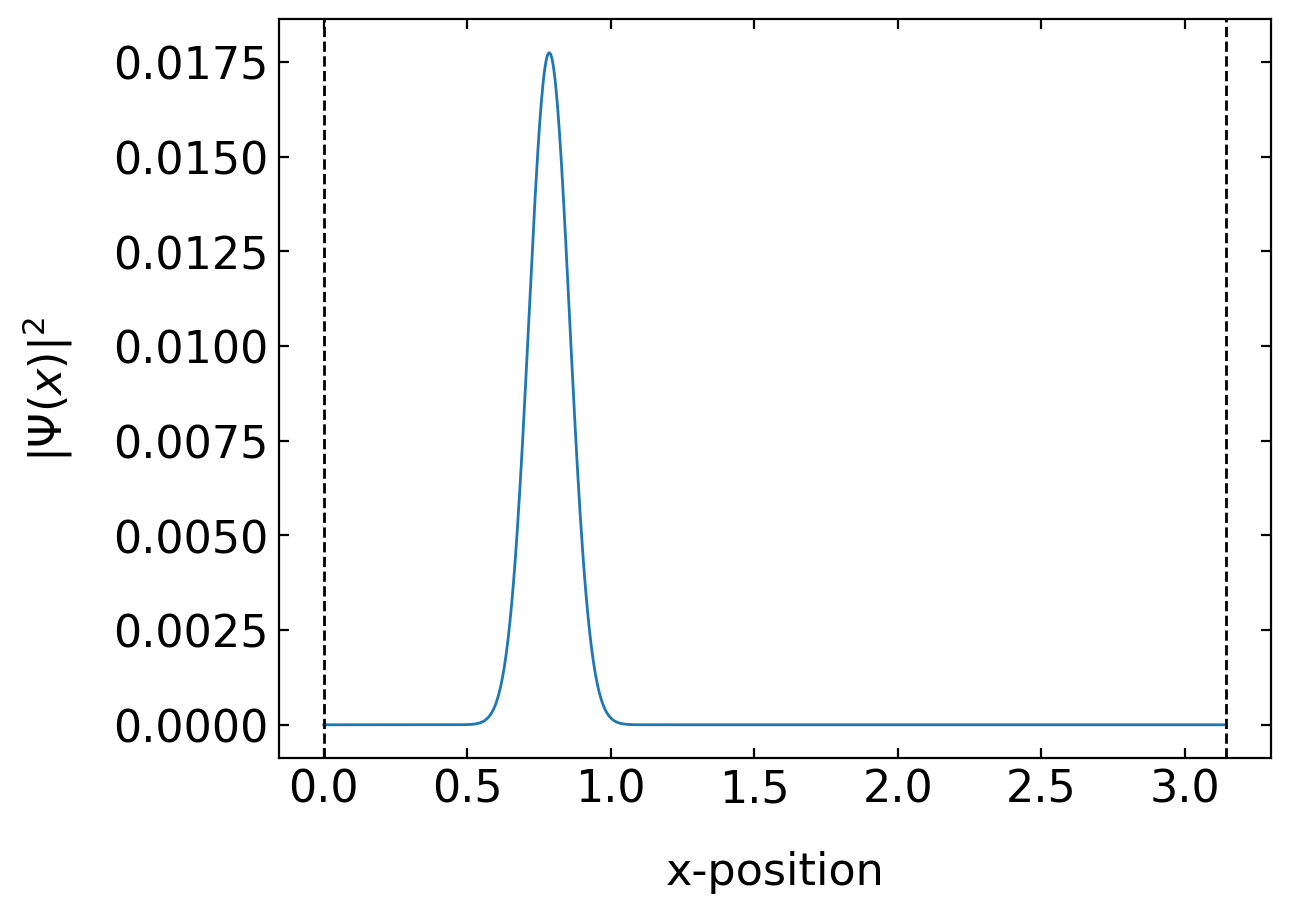

In [5]:
xp=np.linspace(0,np.pi,1000)
##plt.plot(xp,np.abs(wave(xp))**2)
plt.plot(xp,np.abs(gauss_x(xp,0.1,np.pi/4,0))**2)
plt.xlabel('x-position')
plt.ylabel('$|\Psi(x)|^2$')
plt.axvline(x=0,ls='--',color='k')
plt.axvline(x=np.pi,ls='--',color='k')
plt.show()

### Eigenfunctions

To obtain the initial wavepacket as a representation of eigenfunctions, we just need a function that generates the eigenfunctions of the stationary solution $\Psi_{n}(x)$.

In [6]:
def eigen_f(x,n,d):
    return(np.sin(n*np.pi*x/d)*np.sqrt(2/d))

The initial conditions resemble the coefficients $C_{0n}$, which we obtain by calculating the integral

\begin{equation}
C_{0n}=\int_{0}^{d}\Psi(x,t=0)\Psi_{n}(x)dx
\end{equation}

For that purpose, we just write a simple function `integrate` that integrates with our box method. `integrate` takes as arguments the function to integrate, the boundaries for the integration as well as additional parameters for the function.


In [7]:
def integrate(fun,a,b,sigma,x0,k0,*params):
    N=10000
    x=np.linspace(0,np.pi,N)
    fu=fun(x,sigma,x0,k0)*eigen_f(x,*params)
    return(np.sum(fu)*np.abs(a-b)/N)

With the help of this function, we can calculate an array of initial coefficients $C_{0n}$ for a certain number of of eigenfunctions. 

In [8]:
def init(x,num):
    c0n=np.zeros(num,dtype=complex)
    for n in range(len(c0n)):
        c0n[n]=integrate(gauss_x,0,np.pi,0.1,np.pi/4,0,n,np.pi)
    return(c0n)

The values are then calculated by the `init` function and stored in the array `c0n`. Let us try 20 eigenfunctions for the moment.

In [9]:
xp=np.linspace(0,np.pi,1000)
c0n=init(xp,20)

### Quality of the coefficients

We may have a look at the quality of the approximated initial conditions. Above we used 20 of the eigenfunctions. To calculate the final $\Psi(x,t)$ we still need a function which does that.

In [10]:
def w_func(x,d,c0n,t):
    psi=0
    for n in range(len(c0n)):
        psi=psi+c0n[n]*np.exp(-1j*(n**2*np.pi**2)*t/(2*d**2))*eigen_f(x,n,d)
    return(psi)   
 

The plot below shows that the 20 eigenfunctions are not really enough. We should use more. Turns out, that 30 gives a better approximation of the initial conditions.

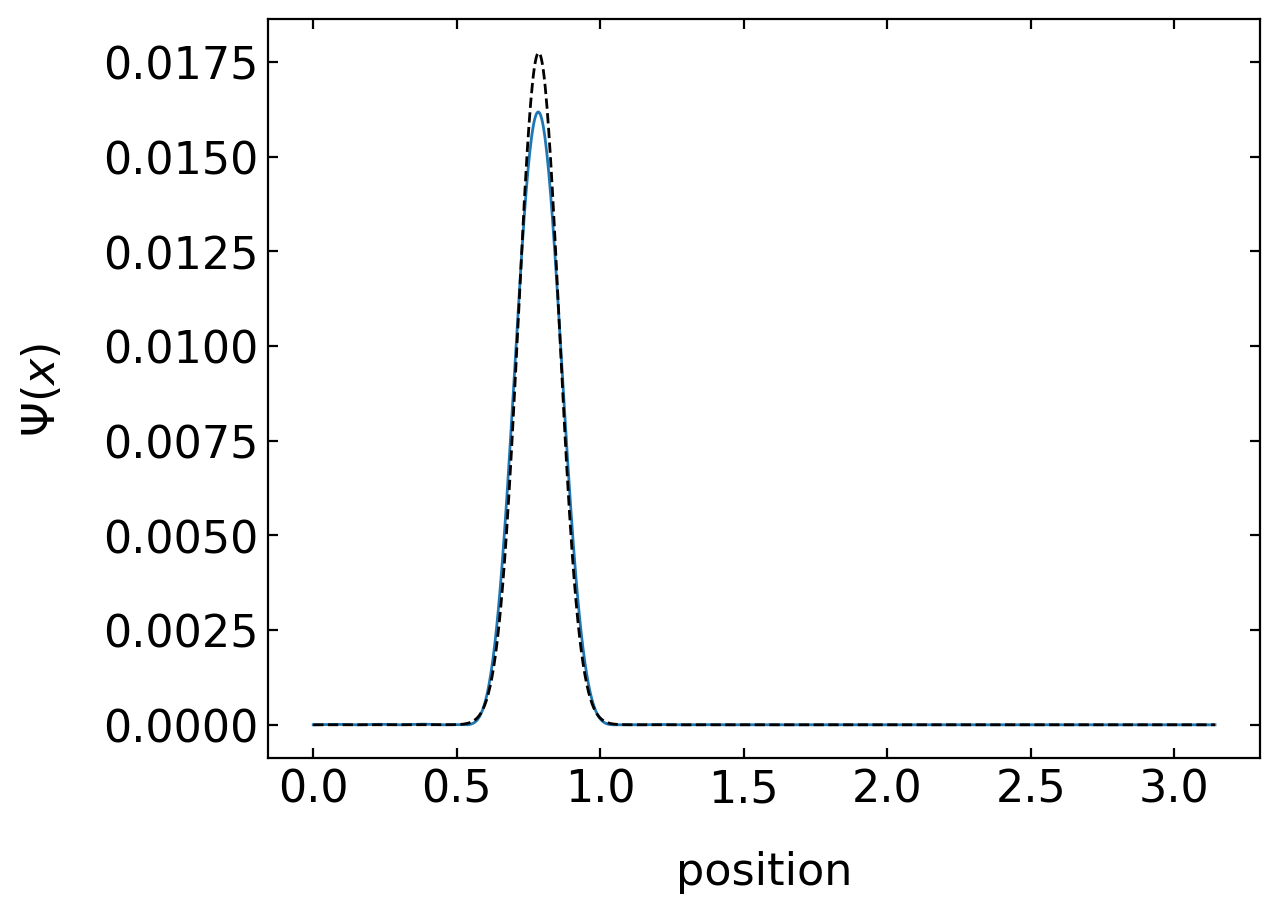

In [11]:
wv=w_func(xp,np.pi,c0n,0)
plt.plot(xp,10*np.abs(wv)**2)
plt.plot(xp,np.abs(gauss_x(xp,0.1,np.pi/4,0))**2,'k--')

plt.xlabel('position')
plt.ylabel(r'$\Psi(x)$')
plt.show()

## Animation

Ok, we are only here to make things move. We want to see the animated wavepacket bouncing back from the walls. This is now a piece of cake, as we have used the animation feature already in the section before.

Just plot the wavefunction without showing it.

In [19]:
xp=np.linspace(0,np.pi,1000)

fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.xlim(-0.1,np.pi+0.1)
plt.ylim(0,0.02)
plt.axvline(x=0,ls='--',color='k')
plt.axvline(x=np.pi,ls='--',color='k')
plt.xlabel('x-position')
plt.ylabel(r'$|\Psi(x,t)|^2$')
plt.tight_layout()  
plt.draw()

background = fig.canvas.copy_from_bbox(ax.bbox)
points=ax.plot(xp,np.abs(w_func(xp,np.pi,c0n,0))**2)[0]
plt.close() 

Then animate everything. The simulation nicely demonstrates that the wavepacket falls apart due to the different time dependence of the prefactors $C_{n}$. Yet, the wave packet is restored after a certain time.

In [22]:
## setup the canvas
canvas = Canvas(width=850, height=480,sync_image_data=False)
display(canvas)

Canvas(height=480, width=850)

In [23]:
for t in np.linspace(0,4,1000):
    fig.canvas.restore_region(background)
    ax.draw_artist(points)
    points.set_data(xp,10*np.abs(w_func(xp,np.pi,c0n,t))**2)

    fig.canvas.blit(ax.bbox)
    X = np.array(fig.canvas.renderer.buffer_rgba())
   
    with hold_canvas(canvas): 
        canvas.clear()
        canvas.put_image_data(X)
        sleep(0.05)

In [1]:
#![Movie](particle_in_box.mov)

## Where to go from here?

The calculations above just included a Gaussian wavepacket without momentum in a box. It is not moving in any direction. A task you may want to tackle is the inclusion of a momentum to see how the particle bounces back and forth.  